### Bonus. Composing Kernels

In lecture and tutorial, we have introduced you to a few (commonly used) kernels:

- **Linear kernel**: $K(u, v) = u \cdot v$.
- **Polynomial kernel** (with degree $d$): $K(u, v) = (u \cdot v)^d$.
- **Gaussian Kernel**: $K(u, v) = e^{-\frac{\lVert u - v \rVert^2}{2 \sigma^2}}$

These kernels work well but... isn't it cool to invent your own kernel?

Recall that kernels are essentially applying **feature transformations** (yet implicitly). Any function that satisfies $K(u, v) = \phi(u) \cdot \phi(v)$ would be a valid kernel, where $\phi$ is the function mapping the original features to the transformed features. In this exercise, let's try to **compose** the existing kernels to create new kernels.

**Your task**: There are 3 tasks (+ a demo task) which walks you through on how you could create new kernels. Go through them one by one.

**Submission**: After working on Tasks 1 - 3, send me a screenshot of your implementation and diagram (for Task 3) before/during the tutorial (for bonus EXP)!

P.S. If no one solves all three tasks, I will still give out bonus EXP to those who solved at least 2. I believe Task 2 would be the hardest one.

In [1]:
from sklearn.svm import SVC
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import math

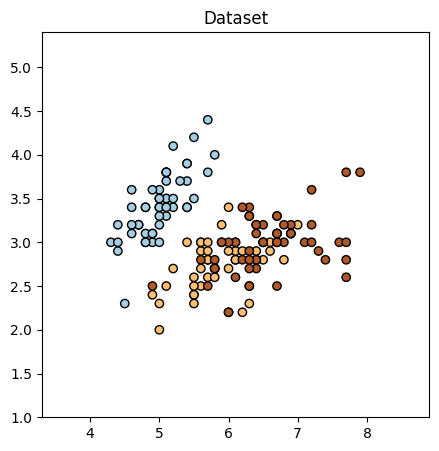

In [2]:
# Load dataset
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

# Adapted from https://www.kaggle.com/code/residentmario/kernels-and-support-vector-machine-regularization
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_test = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title('Dataset')
plt.show()

#### Task 0: Finding Transformed Features (Demo)

In this mini-lab, we will use the kernel trick to solve classification problems using a model called Support Vector Machine (SVM). It is a more advanced version of logistic regression which is out of scope of this course. However, for the purpose of this mini-lab, you may treat it as a logistic classifier.

Same as logistic regression, SVM draws a linear decision boundary in the feature space. The following code snippet shows how to train an SVM classifier with the data above. As you can see, the decision boundary is linear in the original feature space.

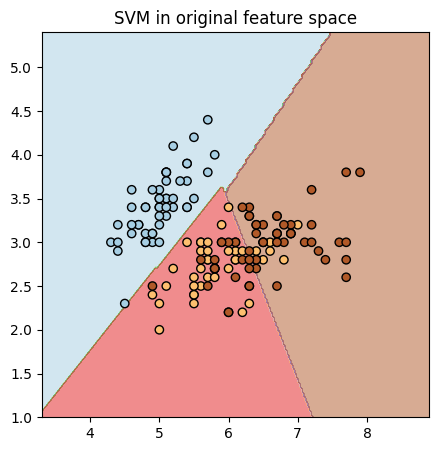

In [3]:
plt.subplots(1, 1, figsize=(5, 5))
svm_linear = SVC(kernel='linear').fit(X, y)
Z_linear = svm_linear.predict(X_test)
Z_linear = Z_linear.reshape(xx.shape)
plt.contourf(xx, yy, Z_linear, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title('SVM in original feature space')
plt.show()

To include non-linear decision boundaries, one can use the kernel trick to implicitly transform the features to a higher-dimensional space.

Given that the kernel trick is equivalent to performing feature transformations, we can actually train an equivalent SVM classifier by making *explicit* feature transformations.

In lecture, we have shown that the kernel $K(u, v) = (u \cdot v)^2$ is equivalent to applying the transformed features $\phi(u) = \begin{bmatrix} u_1^2 & \sqrt{2} u_1 u_2 & u_2^2 \end{bmatrix}^{\top}$, since we have
$$\begin{bmatrix} u_1^2 & \sqrt{2} u_1 u_2 & u_2^2 \end{bmatrix}^{\top} \cdot \begin{bmatrix} v_1^2 & \sqrt{2} v_1 v_2 & v_2^2 \end{bmatrix}^{\top} = (u \cdot v)^2$$

Let's try to verify this with code!

There are two code snippets below. The first one trains a SVM classifier by generating the transformed features $u_1^2$, $\sqrt{2} u_1 u_2$ and $u_2^2$ for each input sample $u$. The second one trains a SVM classifier by applying the kernel function directly. Run them and verify if you obtained the same decision boundaries. It's also useful to study the implementation for Tasks 1 - 3.

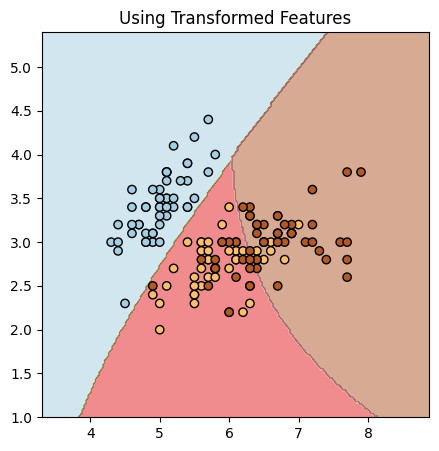

In [4]:
def transform_quadratic(X):
    return np.stack([
        X[:, 0] * X[:, 0], # (u_1)^2
        math.sqrt(2) * X[:, 0] * X[:, 1], # sqrt(2) * u_1 * u_2
        X[:, 1] * X[:, 1], # (u_2)^2
    ], axis=-1)

plt.subplots(1, 1, figsize=(5, 5))

X_transformed = transform_quadratic(X)
svc = SVC(kernel="linear").fit(X_transformed, y)
X_test_transformed = transform_quadratic(X_test)
plt.subplot(1, 1, 1)
Z_transformed = svc.predict(X_test_transformed)
Z_transformed = Z_transformed.reshape(xx.shape)
plt.contourf(xx, yy, Z_transformed, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.title("Using Transformed Features")

plt.show()

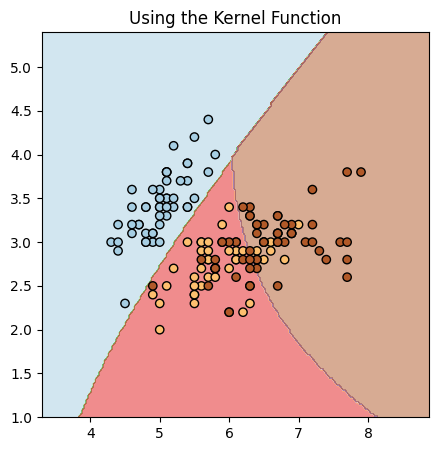

In [5]:
def quadratic_kernel(U, V):
    return np.dot(U, V.T) ** 2

plt.subplots(1, 1, figsize=(5, 5))

svc = SVC(kernel=quadratic_kernel).fit(X, y)
plt.subplot(1, 1, 1)
Z_kernel_func = svc.predict(X_test)
Z_kernel_func = Z_kernel_func.reshape(xx.shape)
plt.contourf(xx, yy, Z_kernel_func, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.title("Using the Kernel Function")

assert np.all(Z_kernel_func == Z_transformed), "SVM gives a different classification"

plt.show()

#### Task 1: Adding Kernel Functions

One attempt is to **add** two kernel functions together, e.g. given that $K_1(u, v) = (u \cdot v)^1$ and $K_2(u, v) = (u \cdot v)^2$ are both valid kernel functions, we can create a new function $K(u, v) = (u \cdot v)^1 + (u \cdot v)^2$.

We can prove that the resulting function *always* a valid kernel function.

Try to prove this by working out the list of transformed features created by this composition. To demonstrate your understanding,  implement your idea at `transform_add` that generates the list of transformed features.

If you implemented the function correctly, the resulting decision boundaries should be same as applying the kernel function.


In [6]:
def transform_add(X1, X2):
    """
    Computes the transformed features equivalent to adding the two kernel functions K1 and K2 together.
    Note that K1 and K2 can have a different number of transformed features.

    Args:
        X1: A two-dimensional ndarray of shape (n, m).
            Contains all input samples, with their features transformed equivalent to the kernel K1.
        X2: A two-dimensional ndarray of shape (n, k).
            Contains all input samples, with their features transformed equivalent to the kernel K2.

    Same as the problem sets, your solution must not involve any iteration.
    """
    return X1

AssertionError: Your SVM gives a different classification

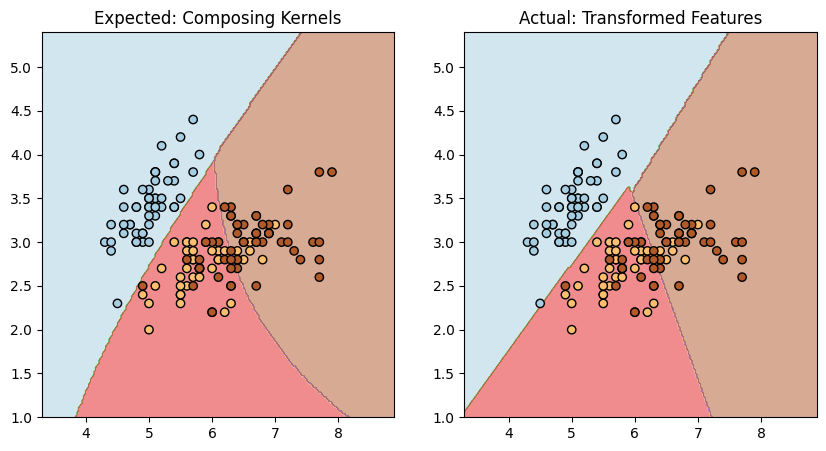

In [7]:
# Test case. Adds the kernels (u ⋅ v)^1 and (u ⋅ v)^2 together.

def my_add_kernel(U, V):
    return np.dot(U, V.T) ** 1 + np.dot(U, V.T) ** 2

def transform_K1(X):
    return X.copy()

def transform_K2(X):
    return np.stack([
        X[:, 0] * X[:, 0],
        math.sqrt(2) * X[:, 0] * X[:, 1],
        X[:, 1] * X[:, 1],
    ], axis=-1)

plt.subplots(1, 2, figsize=(10, 5))

svc = SVC(kernel=my_add_kernel).fit(X, y)
plt.subplot(1, 2, 1)
Z_correct = svc.predict(X_test)
Z_correct = Z_correct.reshape(xx.shape)
plt.contourf(xx, yy, Z_correct, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.title("Expected: Composing Kernels")

X_transformed = transform_add(transform_K1(X), transform_K2(X))
svc = SVC(kernel="linear").fit(X_transformed, y)
X_test_transformed = transform_add(transform_K1(X_test), transform_K2(X_test))
plt.subplot(1, 2, 2)
Z_test = svc.predict(X_test_transformed)
Z_test = Z_test.reshape(xx.shape)
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.title("Actual: Transformed Features")

assert np.all(Z_correct == Z_test), "Your SVM gives a different classification"

plt.show()

#### Task 2: Multiplying Kernel Functions

Another attempt is to **multiply** two kernel functions together, e.g. given that $K_1(u, v) = (u \cdot v)^3$ and $K_2(u, v) = e^{-\frac{\lVert u - v \rVert^2}{2 \sigma^2}}$ are both valid kernel functions, we can create a new function $K(u, v) = e^{-\frac{\lVert u - v \rVert^2}{2 \sigma^2}} (u \cdot v)^3$.

We can also prove that the resulting function *always* a valid kernel function.

Try to prove this by working out the list of transformed features created by this composition. To demonstrate your understanding,  implement your idea at `transform_multiply` that generates the list of transformed features.

If you implemented the function correctly, the resulting decision boundaries should be same as applying the kernel function.


In [8]:
def transform_multiply(X1, X2):
    """
    Computes the transformed features equivalent to multiplying the two kernel functions K1 and K2 together.
    Note that K1 and K2 can have a different number of transformed features.

    Args:
        X1: A two-dimensional ndarray of shape (n, m).
            Contains all input samples, with their features transformed equivalent to the kernel K1.
        X2: A two-dimensional ndarray of shape (n, k).
            Contains all input samples, with their features transformed equivalent to the kernel K2.

    Same as the problem sets, your solution must not involve any iteration.
    """
    return X1

AssertionError: Your SVM gives a different classification

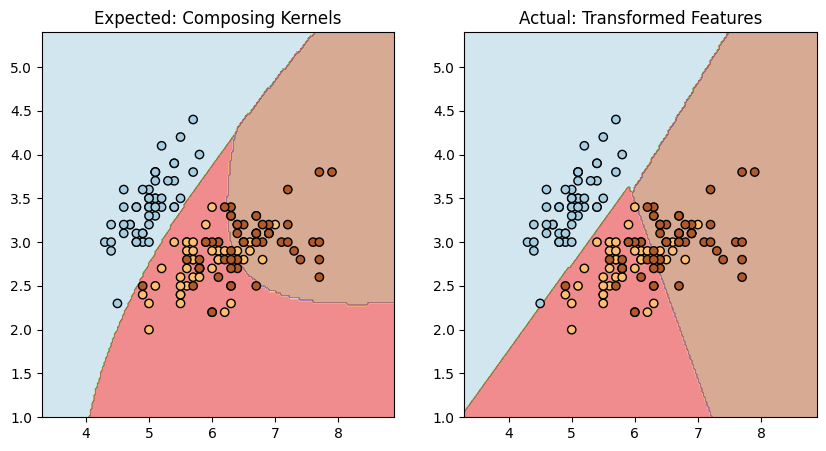

In [9]:
# Test case. Multiplies the kernels (u ⋅ v + 1)^1 and (u ⋅ v)^2 together.

def my_multiply_kernel(U, V):
    return ((np.dot(U, V.T) + 1) ** 1) * (np.dot(U, V.T) ** 2)

def transform_K1(X):
    return np.hstack([
        X,
        np.ones((X.shape[0], 1))
    ])

def transform_K2(X):
    return np.stack([
        X[:, 0] * X[:, 0],
        math.sqrt(2) * X[:, 0] * X[:, 1],
        X[:, 1] * X[:, 1],
    ], axis=-1)

plt.subplots(1, 2, figsize=(10, 5))

svc = SVC(kernel=my_multiply_kernel).fit(X, y)
plt.subplot(1, 2, 1)
Z_correct = svc.predict(X_test)
Z_correct = Z_correct.reshape(xx.shape)
plt.contourf(xx, yy, Z_correct, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.title("Expected: Composing Kernels")

X_transformed = transform_multiply(transform_K1(X), transform_K2(X))
svc = SVC(kernel="linear").fit(X_transformed, y)
X_test_transformed = transform_multiply(transform_K1(X_test), transform_K2(X_test))
plt.subplot(1, 2, 2)
Z_test = svc.predict(X_test_transformed)
Z_test = Z_test.reshape(xx.shape)
plt.contourf(xx, yy, Z_test, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.title("Actual: Transformed Features")

assert np.all(Z_correct == Z_test), "Your SVM gives a different classification"

plt.show()

#### Task 3: Create your own kernel!

Based on these two transformations, create your own kernel function `my_creative_kernel`. Be as creative as possible!

Note: You are not required to work out the set of equivalent transformed features. Infinite-dimensional kernel functions would make this impossible.

In [10]:
def my_creative_kernel(U, V):
    """
    Computes the kernel function K(u, v) over all pairs of data points.

    Args:
        U: A two-dimensional ndarray of shape (n_samples_1, n_features).
        V: A two-dimensional ndarray of shape (n_samples_2, n_features).

    Return:
        A two-dimensional ndarray of shape (n_samples_1, n_samples_2),
        where the (i, j)-th element should contain K(U_i, V_i).

    The linear kernel has been implemented as an example. You should replace
    it by your more creative kernel function.
    """
    return np.dot(U, V.T)

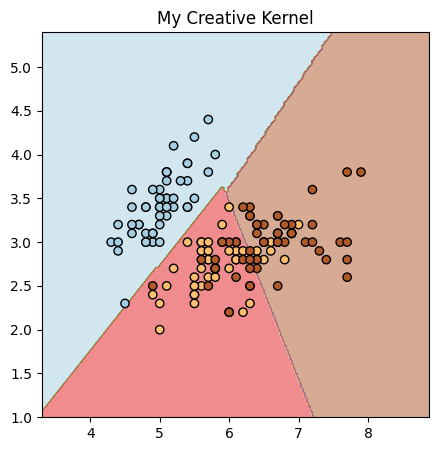

In [11]:
# Test your kernel!

plt.subplots(1, 1, figsize=(5, 5))

svc = SVC(kernel=my_creative_kernel).fit(X, y)
plt.subplot(1, 1, 1)
Z_correct = svc.predict(X_test)
Z_correct = Z_correct.reshape(xx.shape)
plt.contourf(xx, yy, Z_correct, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, linewidth=1, edgecolor='black')
plt.title("My Creative Kernel")

plt.show()